In [1]:
import numpy as np
np.random.seed(1000)

import pandas as pd
import cv2
import keras
import os
import cv2
from PIL import Image


os.environ['KERAS_BACKEND'] = 'tensorflow'


In [2]:
image_directory = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/'
parasitized_images = os.listdir(image_directory + 'Parasitized/')
uninfected_images = os.listdir(image_directory + 'Uninfected/')

In [3]:
SIZE = 64
dataset = []
label = []

In [4]:
for i, image_name in enumerate(parasitized_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image , 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)
    

In [5]:
for i, image_name in enumerate(uninfected_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image , 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

In [6]:
INPUT_SHAPE = (SIZE, SIZE, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32, kernel_size = (3,3),
                           activation='relu', padding = 'same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size = (2,2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)

conv2 = keras.layers.Conv2D(32, kernel_size = (3,3), 
                           activation= 'relu', padding = 'same')(norm1)
pool2 = keras.layers.MaxPooling2D(pool_size = (2,2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(norm2)

hidden1 = keras.layers.Dense(512, activation = 'relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate = 0.2)(norm3)

hidden2 = keras.layers.Dense(256, activation = 'relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate = 0.2)(norm4)

out = keras.layers.Dense(2, activation = 'softmax')(drop4)

model = keras.Model(inputs=inp, outputs=out)
model.compile(optimizer ='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128   

2022-09-03 12:20:28.268186: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)

In [8]:
history = model.fit(np.array(X_train),y_train, batch_size = 64,
                   verbose = 1,
                   epochs = 50,
                   validation_split = 0.1,
                   shuffle = False)

2022-09-03 12:20:30.316179: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
311/311 [==============================] - 31s 94ms/step - loss: 0.4358 - accuracy: 0.8194 - val_loss: 0.2657 - val_accuracy: 0.9166
Epoch 2/50
311/311 [==============================] - 29s 93ms/step - loss: 0.2138 - accuracy: 0.9198 - val_loss: 0.3122 - val_accuracy: 0.8857
Epoch 3/50
311/311 [==============================] - 29s 93ms/step - loss: 0.1763 - accuracy: 0.9385 - val_loss: 0.6041 - val_accuracy: 0.6172
Epoch 4/50
311/311 [==============================] - 29s 93ms/step - loss: 0.1509 - accuracy: 0.9447 - val_loss: 0.2496 - val_accuracy: 0.9270
Epoch 5/50
311/311 [==============================] - 29s 92ms/step - loss: 0.1205 - accuracy: 0.9581 - val_loss: 0.3280 - val_accuracy: 0.8703
Epoch 6/50
311/311 [==============================] - 29s 93ms/step - loss: 0.1038 - accuracy: 0.9624 - val_loss: 0.3770 - val_accuracy: 0.8739
Epoch 7/50
311/311 [==============================] - 29s 93ms/step - loss: 0.0873 - accuracy: 0.9697 - val_loss: 0.1662 - val_accuracy:

In [9]:
print("Test_Accuracy: {:.2f}%".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))

173/173 [==============================] - 2s 14ms/step - loss: 0.4096 - accuracy: 0.9537
Test_Accuracy: 95.37%


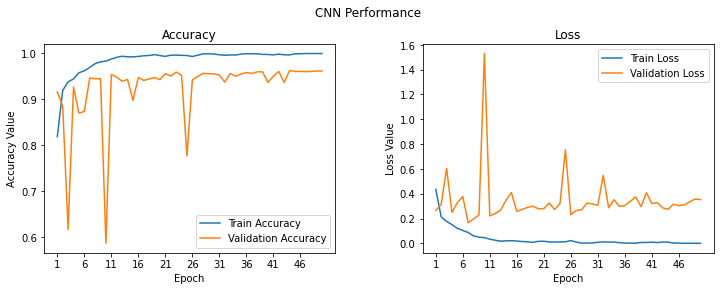

In [10]:
import matplotlib.pyplot as plt
f, (ax1 , ax2) = plt.subplots(1, 2, figsize = (12,4))
t = f.suptitle('CNN Performance', fontsize = 12)
f.subplots_adjust(top=0.85, wspace = 0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label = "Train Accuracy")
ax1.plot(epoch_list, history.history['val_accuracy'], label = "Validation Accuracy")
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")




Actual Label : 18, False Label : 2 


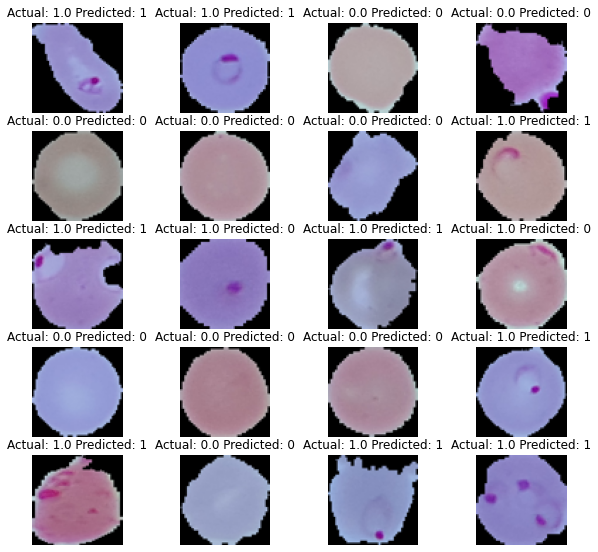

In [11]:
fig = plt.figure(figsize=(10,10))

countTrue = 0
countFalse = 0

for j in range(20):
    fig.add_subplot(5,4,j+1)
    input_img = np.expand_dims(X_test[j], axis=0)
    result = model.predict(input_img)
    plt.imshow(X_test[j])
    plt.axis('off')
    plt.title('Actual: {} Predicted: {}'.format(y_test[j][0], int(result[0][0])))
    plt.subplots_adjust(top=0.85, wspace = 0.3)
    if y_test[j][0] == int(result[0][0]):
        countTrue += 1
    else:
        countFalse += 1
        
print('Actual Label : {}, False Label : {} '.format(countTrue,countFalse))